In [1]:
import pandas as pd 
import numpy as np 
from pandas_datareader import data as web

from stockstats import StockDataFrame as Sdf

import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
btc = web.DataReader('BTC-USD', data_source='yahoo', start='01-01-2019')

btc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-01,3850.913818,3707.231201,3746.713379,3843.520020,4.324201e+09,3843.520020
2019-01-02,3947.981201,3817.409424,3849.216309,3943.409424,5.244857e+09,3943.409424
2019-01-03,3935.685059,3826.222900,3931.048584,3836.741211,4.530215e+09,3836.741211
2019-01-04,3865.934570,3783.853760,3832.040039,3857.717529,4.847965e+09,3857.717529
2019-01-05,3904.903076,3836.900146,3851.973877,3845.194580,5.137610e+09,3845.194580


In [3]:
btc  = Sdf.retype(btc)

In [4]:
btc['macds'] = btc['macds']
btc['macd'] = btc['macd'] 

In [5]:
signal = btc['macds']       
macd   = btc['macd']        
strategy = ['Empty'] # empty df where values will be put based on trading strategy conditions

In [6]:
for i in range(1, len(signal)):
    #                          
    if macd[i] > signal[i] and macd[i - 1] <= signal[i - 1]: #generate buy signal based on bullish macds crossover
        strategy.append('buy')
    #                          
    elif macd[i] < signal[i] and macd[i - 1] >= signal[i - 1]: #generate sell signal based on macds bearish crossover 
        strategy.append('sell')
    #                          
    else: # if neither condition is met hold
        strategy.append('hold')

btc['Strategy'] = strategy

In [7]:
print(btc['Strategy'])

Date
2019-01-01    Empty
2019-01-02      buy
2019-01-03     sell
2019-01-04     hold
2019-01-05     hold
              ...  
2021-03-02     hold
2021-03-03     hold
2021-03-04     hold
2021-03-05     hold
2021-03-07     hold
Name: Strategy, Length: 792, dtype: object


In [8]:
btc['MACD_Hist'] = btc['macd'] - btc['macds']

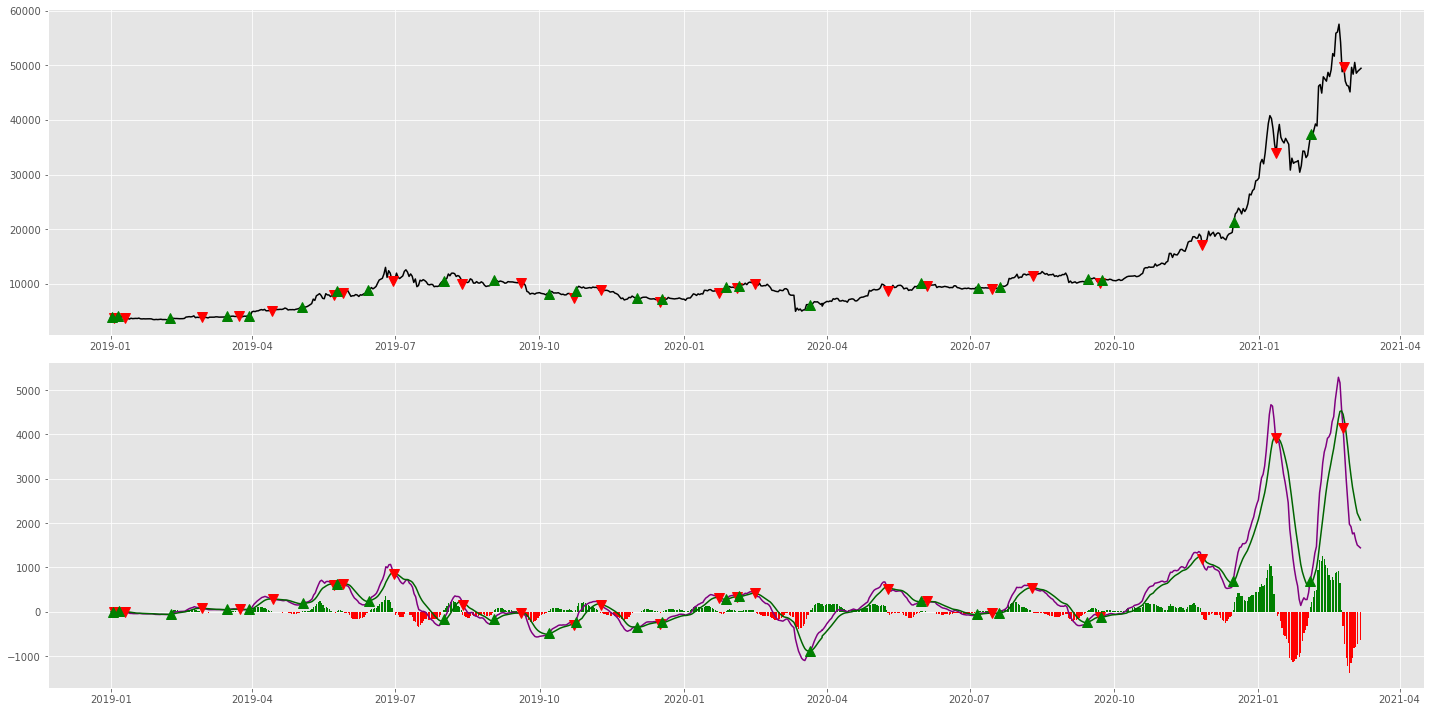

In [9]:
f, (ax1, ax2) = plt.subplots(nrows=2, ncols = 1, figsize=(20,10))

ax1.plot(btc['close'], color = 'black')


ax1.plot(btc.loc[btc.Strategy == 'sell'].index, 
         btc.close[btc.Strategy == 'sell'],
         'v', markersize=10, color='red')

ax1.plot(btc.loc[btc.Strategy == 'buy'].index, 
         btc.close[btc.Strategy == 'buy'],
         '^', markersize=10, color='green')

ax2.plot(btc['macd'], color ='purple')
ax2.plot(btc['macds'], color = 'darkgreen')
ax2.bar(btc.index, btc['MACD_Hist'], label='MACD_bars', color=(btc['MACD_Hist'] > 0).map({True: 'g', False: 'r'}))

ax2.plot(btc.loc[btc.Strategy == 'sell'].index, 
         btc.macd[btc.Strategy == 'sell'],
         'v', markersize=10, color='red')

ax2.plot(btc.loc[btc.Strategy == 'buy'].index, 
         btc.macd[btc.Strategy == 'buy'],
         '^', markersize=10, color='green')

plt.tight_layout()

In [10]:
from fastquant import backtest #library for backtesting strategy

In [16]:
df = btc['close']
df.tail()

Date
2021-03-02    48378.988281
2021-03-03    50538.242188
2021-03-04    48561.167969
2021-03-05    48927.304688
2021-03-07    49468.304688
Name: close, dtype: float64

In [17]:
df = pd.DataFrame(df)
df.tail()

,close
Date,
2021-03-02,48378.988281
2021-03-03,50538.242188
2021-03-04,48561.167969
2021-03-05,48927.304688
2021-03-07,49468.304688


In [19]:
import warnings
warnings.filterwarnings('ignore')

Starting Portfolio Value: 100000.00
2021-03-07, ===Global level arguments===
2021-03-07, init_cash : 100000
2021-03-07, buy_prop : 1
2021-03-07, sell_prop : 1
2021-03-07, commission : 0.0075
2021-03-07, stop_loss : 0
2021-03-07, stop_trail : 0
===Strategy level arguments===
fast_period : 12
slow_period : 26
signal_period : 9
sma_period : 30
dir_period : 10
2021-03-07, Final Portfolio Value: 256178.58855468748
2021-03-07, Final PnL: 156178.59
Time used (seconds): 0.5200679302215576
Number of strat runs: 1
Number of strats per run: 1
Strat names: ['macd']
**************************************************
--------------------------------------------------
Strategy Parameters	init_cash:100000	buy_prop:1	sell_prop:1	commission:0.0075	stop_loss:0	stop_trail:0	execution_type:close	channel:	symbol:	allow_short:False	short_max:1.5	add_cash_amount:0	add_cash_freq:M	fast_period:12	slow_period:26	signal_period:9	sma_period:30	dir_period:10
Returns	rtot:0.9407046268153954	ravg:0.001190765350399234

<IPython.core.display.Javascript object>

,strat_id,init_cash,buy_prop,sell_prop,commission,stop_loss,stop_trail,execution_type,channel,symbol,...,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value
0,0,100000,1,1,0.0075,0,0,close,,,...,34.995717,102,11.076649,31910.632764,"{'len': 243, 'drawdown': 35.83937973974354, 'm...",35.83938,242,0.614503,156178.59,256178.588555


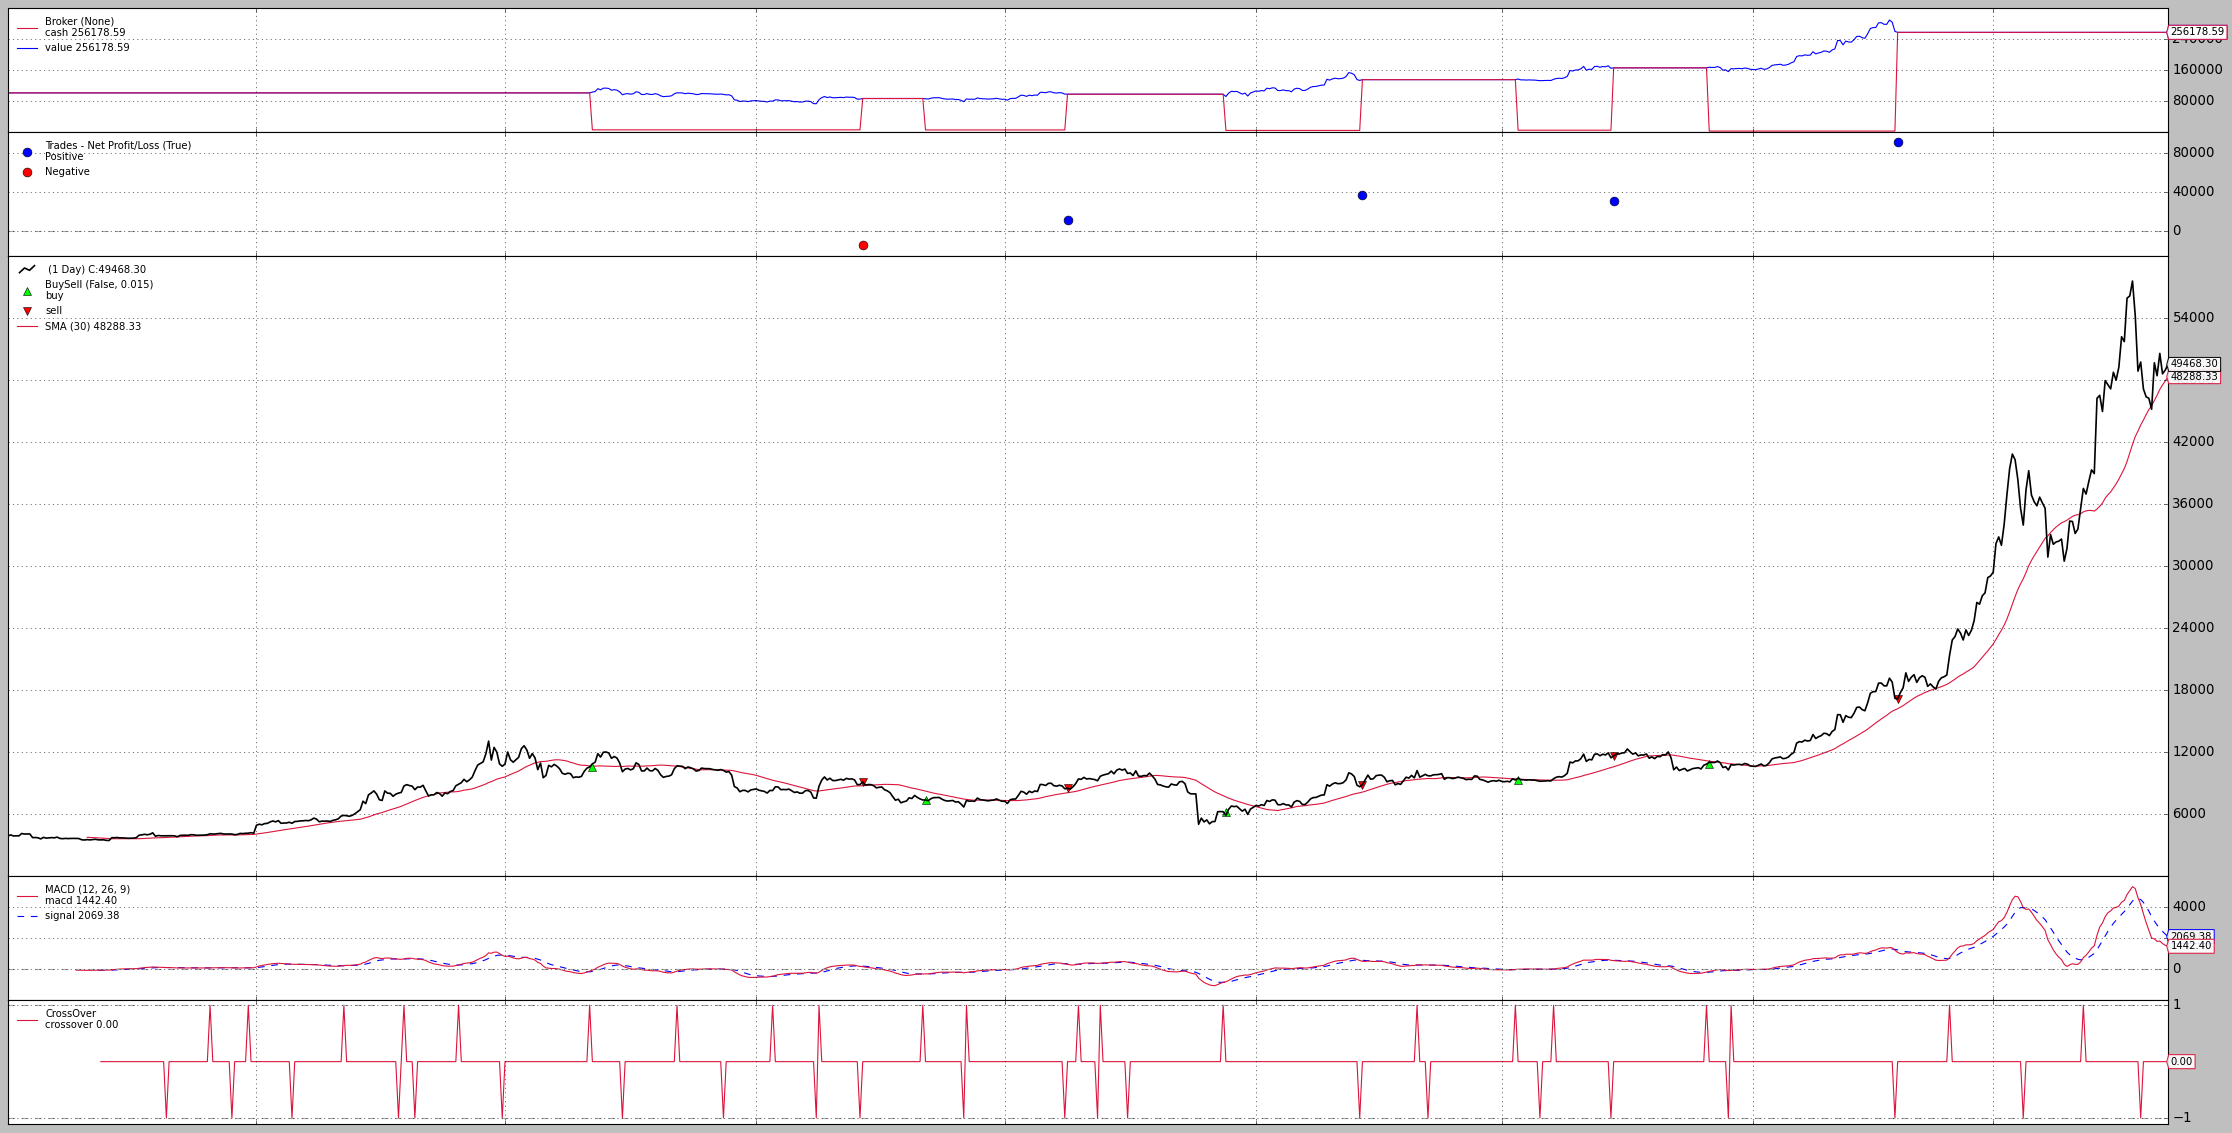

In [20]:
backtest('macd', df, fast_period=12, slow_period=26, signal_period=9, sma_period=30, dir_period=10)

In [21]:
# Starting Portfolio Value: 100,000.00
# Final Portfolio Value: 250,000 
# PnL = 150,000 

# However, things to consider is that the bitcoin price is up more than 8x since 2019 and a simple buy and hold strategy would have 
# outperformed this trading strategy considerably